In [1]:
import pandas as pd
import import_ipynb

datapath = "../data/" 

# Type and unit declarations

In [108]:
from pandas.api.types import CategoricalDtype
from astropy import units as u

dopingCat = CategoricalDtype(
    categories=['int', 'r96', 'r48', 'r24', 'r16'],
    ordered=True                     
)

cappingCat = CategoricalDtype(
    categories = ['cap', 'nocap'],
    ordered=False  # maybe change this...
)

annealCat = CategoricalDtype(
    categories=['asdep'] + [f'{T}C' for T in range(300, 750, 50)],
    ordered = True
)

SEUnits = {
    # thicknesses
    't_AlOx' : u.nm,
    't_AZO' : u.nm,
    't_SiOx' : u.nm,
    't_int' : u.nm,
    # AZO fit parameters
    'AZO_Einf' : u.eV,
    ## Tauc-Lorentz
    'TL_Amp' : u.eV,
    'TL_E0': u.eV,
    'TL_Eg': u.eV,
    'TL_Br': u.eV,
    ## free carrier absorption
    'omega_t' : u.eV,
    'omega_p' : u.eV,
    # Misc
    'roughness' : u.nm,
    'MSE' : None,
    'offset_angle' : None,
}

HallUnits = {
    'mu_H'  : u.m**2 /(u.V* u.s), # m^2 V-1 s-1
    'n'     : u.m**(-3), # m^-3
    'n_sh'  : u.m**(-2), # m^-2
    'R_H'   : u.m**3 /u.C, # m^3 C^-1
    'R_H_sh': u.m**2 /u.C, # m^2 C^-1
    'rho'   : u.Ohm * u.m, # Ohm m
    'rho_sh': u.Ohm, # Ohm sq
    'V_H'   : u.V, # V
    'd_AZO_Hall'     : u.nm, # nm
}



# Get SE fit parameters

In [3]:
columnNameMap = {
    'MSE' : 'MSE',
    'Roughness (nm)' : 'roughness',
    'Thickness # 4 (nm)' : 't_AlOx',
    'Thickness # 3 (nm)' : 't_AZO',
    'Thickness # 2 (nm)' : 't_SiOx',
    'Thickness # 1 (nm)' : 't_int',
    'Einf' : 'AZO_Einf',
    'Amp1' : 'TL_Amp',
    'Br1' : 'TL_Br',
    'Eo1' : 'TL_E0',
    'Eg1' : 'TL_Eg',
    'A2' : 'omega_p',
    'B2' : 'omega_t',
    'Angle Offset' : 'offset_angle',
    ' ' : 'sample_name'
}

def preFilter(df):
    # sample r16_cap_asdep_no2 should be removed
    return df[df.sample_name != 'r16_cap_asdep_no2']

def nameToConditions(df):
    def splitNames(x):
        values = x.sample_name.split('_')
        keys = ['doping', 'capping', 'anneal']
        return pd.Series({**x, **dict(zip(keys, values))})
    return (df
            .apply(splitNames, axis = 1)
            .drop(columns = 'sample_name')
            .astype({'doping' : dopingCat, 'capping' : cappingCat, 'anneal' : annealCat})
           )

def getData_SE(csvFile):
    return (pd
            .read_csv(csvFile, sep = '\t')
            .rename(columns = columnNameMap)
            .pipe(preFilter)
            .pipe(nameToConditions)
    )

dataSE = (
    pd
    .concat(
        [getData_SE(datapath + '/SE_anneal/capped_data/parameters.csv'),
         getData_SE(datapath + '/SE_anneal/uncapped_data/parameters.csv')
        ]
    )
)

# get Hall data

In [122]:
from hall_data import get_df
dataHall = (
    get_df()
    .astype({'doping' : dopingCat, 'capping' : cappingCat, 'anneal' : annealCat})
    .rename(columns = {'d' : 'd_AZO_Hall'})
    .drop(columns = 'filename')
)

In [5]:
#dataSE.merge(dataHall, on = ['doping', 'capping', 'anneal'], how = 'outer')

# get $\rho_c$ data

In [6]:
from rho_c_data import dataRho as inputDataRho

importing Jupyter notebook from rho_c_data.ipynb


In [7]:
def concatMultiIndex(df):
    df.columns = ['_'.join(x[::-1]).replace('%', '') for x in df.columns.to_flat_index()]
    return df

dataRho = (inputDataRho
 .query('substrate != "pSi"')
 .assign(capping = 'cap')
 .astype({'doping' : dopingCat, 'capping' : cappingCat, 'anneal' : annealCat})
 .groupby(['doping', 'anneal', 'capping', 'substrate'])['rho_c']
 .describe()
 .unstack()
 .pipe(concatMultiIndex)
# .rename(columns = lambda x : '_'.join(x), level = 0)
 .reset_index()
)

# Merge all data

In [8]:
HSE = (
    dataSE
    .merge(dataHall, on = ['doping', 'capping', 'anneal'], how = 'outer')
)

In [9]:
data = (
    HSE
    .merge(dataRho , on = ['doping', 'capping', 'anneal'], how = 'outer')
)

# Recalculate bulk properties from SE thickness

In [10]:
def recalc_bulk(idf):
    t_AZO = SEUnits['t_AZO']*idf.t_AZO.values
    return (idf
            .assign(
                rho_corr = lambda df: (t_AZO*HallUnits['rho_sh']*df.rho_sh.values).to_value(HallUnits['rho']),
                n_corr   = lambda df: (HallUnits['n_sh'  ]*df.n_sh.values/t_AZO  ).to_value(HallUnits['n']),
                R_H_corr = lambda df: (t_AZO*HallUnits['R_H_sh']*df.R_H_sh.values).to_value(HallUnits['R_H']),
            )
           )

In [11]:
HSE = (
    HSE
    .pipe(recalc_bulk)    
)

Index(['MSE', 'roughness', 't_AlOx', 't_AZO', 'AZO_Einf', 'TL_Amp', 'TL_Br',
       'TL_E0', 'TL_Eg', 'omega_p', 'omega_t', 't_SiOx', 't_int',
       'offset_angle', 'doping', 'capping', 'anneal', 'mu_H', 'Carrier type',
       'n', 'n_sh', 'R_H', 'R_H_sh', 'rho', 'rho_sh', 'V_H', 'd_AZO_Hall',
       'rho_corr', 'n_corr', 'R_H_corr'],
      dtype='object')


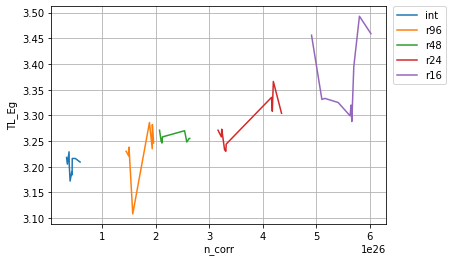

In [89]:
if __name__ == '__main__':
    import seaborn as sns
    from matplotlib import pyplot as plt
    
    print(HSE.columns)
    
    def plotvar(x):
        #return (x.omega_p**2)/(x.omega_t*x.n_corr)
        return x.omega_p
    
    p = sns.lineplot(
        data = (HSE
                .assign(pv = plotvar)
                .pipe(lambda df: df[df.capping == 'cap'])
               ),
        x = 'n_corr',
        y = 'TL_Eg',
        #style = 'capping',
        hue = 'doping',
    )
    
    #p.set(yscale = 'log')
    p.grid(which = 'both')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


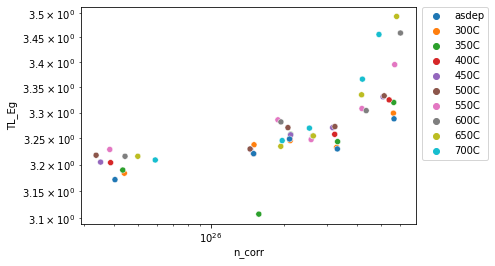

In [91]:
if __name__ == '__main__':
    import seaborn as sns
    import numpy as np
    from matplotlib import pyplot as plt
    
    p = sns.scatterplot(
        data = (HSE
                .pipe(lambda df: df[df.capping == 'cap'])
                .assign(sqrt_n = lambda x: x.n_corr ** 0.5)
                .assign(m_eff = lambda x: x.n_corr/(x.omega_p **2))
                .assign(m_eff_32 = lambda x: x.m_eff ** (3/2))
                .assign(mu_opt = lambda x: (x.omega_p **2)/(x.omega_t * x.n_corr))
                .assign(scat_m_eff = lambda x: x.omega_t * x.m_eff)
                .assign(n_expected = lambda x: x.m_eff_32*np.exp(-x.TL_Eg/(2*0.0259)))
               ),
        x = 'n_corr',
        y = 'TL_Eg',
        hue = 'anneal',
    )
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    p.set(yscale = 'log', xscale = 'log')